In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('cp.csv')
df.head()

,Hotel_Address,City,merged_review_text,Reviewer_Score
0,19 21 Penywern Road Kensington and Chelsea Lon...,London,The staff were a bit cold at first but they g...,8.3
1,Singel 303 309 Amsterdam City Center 1012 WJ A...,Amsterdam,Nothing View from room Location,10.0
2,18 Avenue De Suffren Entr e au 22 rue Jean Rey...,Paris,The Eiffel is blocked by another building we ...,10.0
3,K rntner Ring 9 01 Innere Stadt 1010 Vienna Au...,Vienna,Nothing Attention to detail Glad and smiley s...,9.6
4,Kleine Stadtgutgasse 4 02 Leopoldstadt 1020 Vi...,Vienna,Nothing negative to mention Great location 15...,8.8


Let's decide what will suit us better - spacy or g.api?

In [3]:
import spacy
from google.cloud import language_v1
from google.oauth2 import service_account
creds = service_account.Credentials.from_service_account_file('./project-hard07-78e511d6319d.json')
client = language_v1.LanguageServiceClient(credentials=creds)
language = "en"
type_ = language_v1.Document.Type.PLAIN_TEXT
encoding_type = language_v1.EncodingType.UTF8

https://googleapis.dev/python/language/latest/usage.html According to the documentation, the Google language API does not have the desired functionality, so I will continue using spaCy

In [4]:
nlp = spacy.load('en_core_web_md') #loading the language model

For our desired outcome we need the word type classification feature, which works as following:

In [5]:
doc = nlp("This is a sentence.")

pos = pd.DataFrame()

for token in doc:
    pos.loc[token, "pos"] = token.pos
    pos.loc[token, "pos_"] = token.pos_
    pos.loc[token, "explained"] = spacy.explain(token.pos_)

pos

,pos,pos_,explained
This,90.0,DET,determiner
is,87.0,AUX,auxiliary
a,90.0,DET,determiner
sentence,92.0,NOUN,noun
.,97.0,PUNCT,punctuation


So the idea is
- Get the values for every review
- encode the counts into a new dataframe with value counts for every single review
- recalculate the review counts into proportions, which I believe makes more sense and will make the space less sparse, which could later help the clustering algorithm

- Za kazdou review dostanu takovou tabulku
- z tabulky dostat counts
- prevest counts do prislusnych sloupcu
- prepocitat na proporce

In [6]:
doc = nlp(df['merged_review_text'][42])
pos = pd.DataFrame()
for token in doc:
    pos.loc[token,'pos_'] = token.pos_
    
pos

,pos_
,SPACE
Shower,PROPN
head,VERB
too,ADV
close,ADV
to,ADP
wall,PROPN
Tub,PROPN
narrow,ADJ
Location,PROPN


In [7]:
type_list = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON',
             'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X','SPACE']
#now to figure out how to get the counts row
def vectorizer(data_column):
    
    '''This very suboptimal function takes a data column and creates a new dataframe based on that column. It creates
        a row containing the word type counts for each string (review) and concatenates the row to the new vectorized
        dataframe. Eventually the function divides the values by the total number of words to get proportions.
        
        The worst iterative function in the history of iterative functions, maybe ever.
        '''
    
    vectorized_df = pd.DataFrame(columns=type_list)
    for row in data_column.values:
        doc = nlp(row)
        pos = pd.DataFrame()
        for token in doc:
            pos.loc[token,'pos_'] = token.pos_
        #have the pos table    
        vector = pd.DataFrame(pos['pos_'].value_counts()).reset_index()
        vector = vector.transpose()
        new_header = vector.iloc[0]
        vector = vector[1:]
        vector.columns = new_header #there's definitely a better, faster way but whatever
        vectorized_df = pd.concat([vectorized_df,vector]) #or the following, takes much more time though
        #vectorized_df = vectorized_df.append(vector)
    vectorized_df = vectorized_df.drop('SPACE', axis=1)
    vectorized_df.fillna(0, inplace=True)
    
    vectorized_df['sum'] = vectorized_df.sum(axis=1)
    vectorized_df.loc[:,"ADJ":"X"] = vectorized_df.loc[:,"ADJ":"X"].div(vectorized_df["sum"], axis=0)
    #vectorized_df = vectorized_df.drop('sum', axis=1) #for the sake of the clustering I decided NOT to drop the sum and include
    #it in the resulting dataset since by making proportions I lose information about word count

    
    return vectorized_df

In [8]:
please = vectorizer(df['merged_review_text'][:5])
please

,ADJ,ADP,ADV,AUX,CONJ,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,sum
pos_,0.108333,0.133333,0.041667,0.075000,0.0,0.050000,0.175000,0.000000,0.208333,0.008333,0.008333,0.050000,0.033333,0.0,0.008333,0.0,0.100000,0.0,120
pos_,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.200000,0.200000,0.0,0.000000,0.0,0.000000,0.0,5
pos_,0.037037,0.111111,0.037037,0.074074,0.0,0.000000,0.185185,0.000000,0.222222,0.000000,0.000000,0.037037,0.185185,0.0,0.037037,0.0,0.074074,0.0,27
pos_,0.090909,0.090909,0.000000,0.000000,0.0,0.090909,0.000000,0.090909,0.363636,0.000000,0.090909,0.090909,0.000000,0.0,0.000000,0.0,0.090909,0.0,11
pos_,0.285714,0.047619,0.047619,0.000000,0.0,0.047619,0.000000,0.000000,0.380952,0.047619,0.047619,0.047619,0.000000,0.0,0.000000,0.0,0.047619,0.0,21


Now I need a df with ALL possible types as columns and match the values from the vectorizer function output

In [9]:
#ah it works, let's give it the big one then

vectorized_df = vectorizer(df['merged_review_text'])
vectorized_df.head()

,ADJ,ADP,ADV,AUX,CONJ,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,sum
pos_,0.108333,0.133333,0.041667,0.075000,0.0,0.050000,0.175000,0.000000,0.208333,0.008333,0.008333,0.050000,0.033333,0.0,0.008333,0.0,0.100000,0.0,120
pos_,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.200000,0.200000,0.0,0.000000,0.0,0.000000,0.0,5
pos_,0.037037,0.111111,0.037037,0.074074,0.0,0.000000,0.185185,0.000000,0.222222,0.000000,0.000000,0.037037,0.185185,0.0,0.037037,0.0,0.074074,0.0,27
pos_,0.090909,0.090909,0.000000,0.000000,0.0,0.090909,0.000000,0.090909,0.363636,0.000000,0.090909,0.090909,0.000000,0.0,0.000000,0.0,0.090909,0.0,11
pos_,0.285714,0.047619,0.047619,0.000000,0.0,0.047619,0.000000,0.000000,0.380952,0.047619,0.047619,0.047619,0.000000,0.0,0.000000,0.0,0.047619,0.0,21


In [10]:
len(vectorized_df)

10000

In [11]:
vectorized_df.to_csv('cp2_v2.csv',index=False)

In [12]:
vectorized_df.isnull().sum() #there might be some empty strings

ADJ      4
ADP      4
ADV      4
AUX      4
CONJ     4
CCONJ    4
DET      4
INTJ     4
NOUN     4
NUM      4
PART     4
PRON     4
PROPN    4
PUNCT    4
SCONJ    4
SYM      4
VERB     4
X        4
sum      0
dtype: int64

In [13]:
vectorized_df_clear = vectorized_df.dropna()
len(vectorized_df_clear) #all clear now

9996

The worst part is behind us, let's create some clusters now

btw. from Pandas documentation:

Iteratively appending rows to a DataFrame can be more computationally intensive than a single concatenate. A better solution is to append those rows to a list and then concatenate the list with the original DataFrame all at once.

Well im not sure how to this task using a list since there are unmatched columns, so whatever

The append solution takes actually much longer than the concat solution, damn

In [14]:
#let's make some clustering... kmeans or dbscan? Let's compare them both
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

In [15]:
def model_inertias(features, max_cl=21):
    try_cl = range(1,max_cl)
    inertias = []
    
    for i in try_cl:
        kmeans = KMeans(init='random', n_clusters = i, n_init = 10, max_iter = 300, random_state = 42)
        kmeans.fit(features)
        inertia = kmeans.inertia_
        inertias.append(inertia)

    plt.plot(range(1,max_cl), inertias)
    plt.xticks(range(1,max_cl))
    plt.title('Elbow method for KMeans')
    plt.show()

In [16]:
def model_sscore(features, max_cl = 21):
    scores = []
    try_cl = range(2,max_cl)
    
    for i in try_cl:
        kmeans = KMeans(init='random', n_clusters = i, n_init = 10, max_iter = 300, random_state = 42)
        kmeans.fit(features)
        sil = silhouette_score(features, kmeans.labels_)
        scores.append(sil)
        
    plt.plot(range(2,max_cl), scores)
    plt.xticks(range(2,max_cl))
    plt.title('Silhouette scores for KMeans')
    plt.show()

KMeans like this seems to be pointless, let's add PCA and make a proper pipeline

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 2, random_state = 42))
]) #I need to keep this fit for the purpose of the final prediction

In [43]:
ddf = vectorized_df_clear.copy()
ddf.head()

,ADJ,ADP,ADV,AUX,CONJ,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,sum
pos_,0.108333,0.133333,0.041667,0.075000,0.0,0.050000,0.175000,0.000000,0.208333,0.008333,0.008333,0.050000,0.033333,0.0,0.008333,0.0,0.100000,0.0,120
pos_,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.200000,0.200000,0.0,0.000000,0.0,0.000000,0.0,5
pos_,0.037037,0.111111,0.037037,0.074074,0.0,0.000000,0.185185,0.000000,0.222222,0.000000,0.000000,0.037037,0.185185,0.0,0.037037,0.0,0.074074,0.0,27
pos_,0.090909,0.090909,0.000000,0.000000,0.0,0.090909,0.000000,0.090909,0.363636,0.000000,0.090909,0.090909,0.000000,0.0,0.000000,0.0,0.090909,0.0,11
pos_,0.285714,0.047619,0.047619,0.000000,0.0,0.047619,0.000000,0.000000,0.380952,0.047619,0.047619,0.047619,0.000000,0.0,0.000000,0.0,0.047619,0.0,21


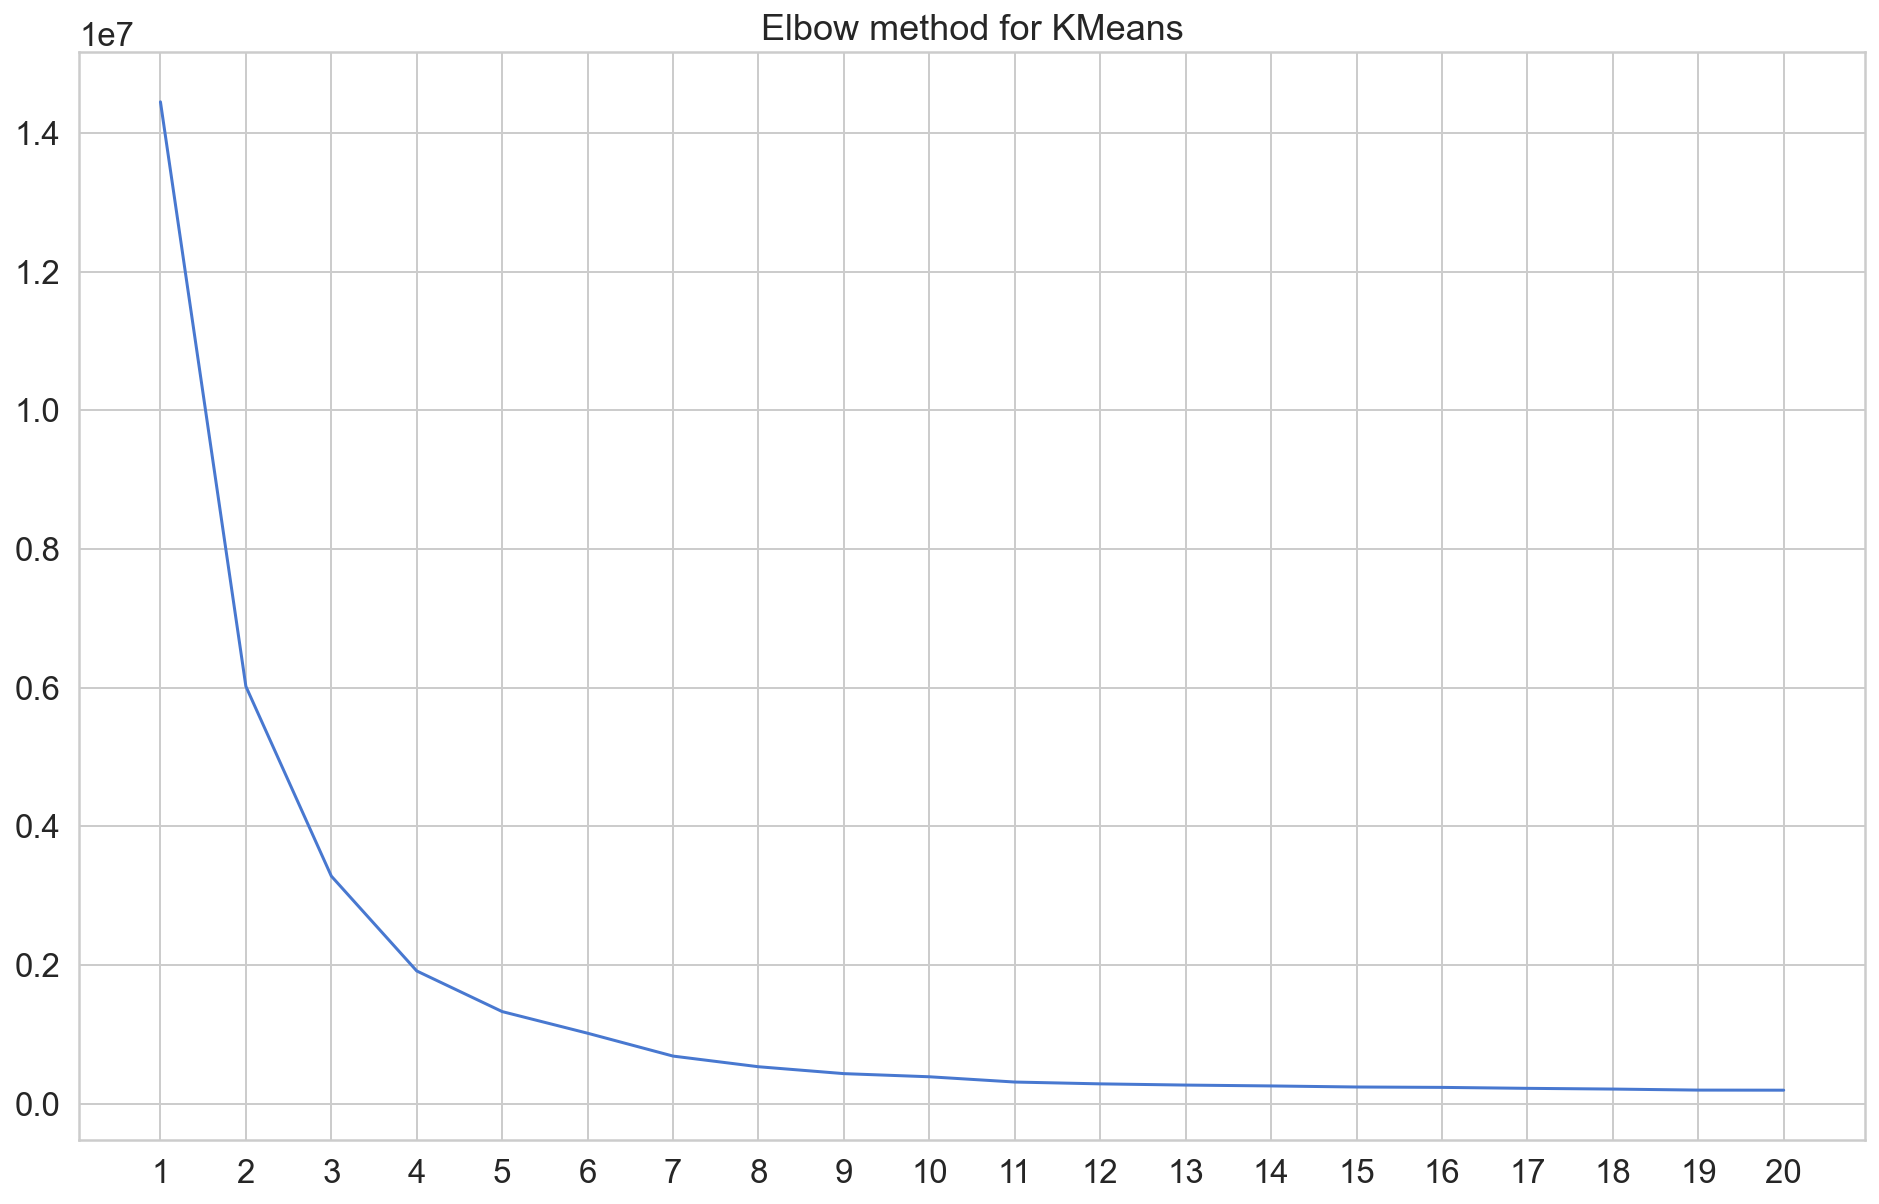

In [44]:
model_inertias(ddf)

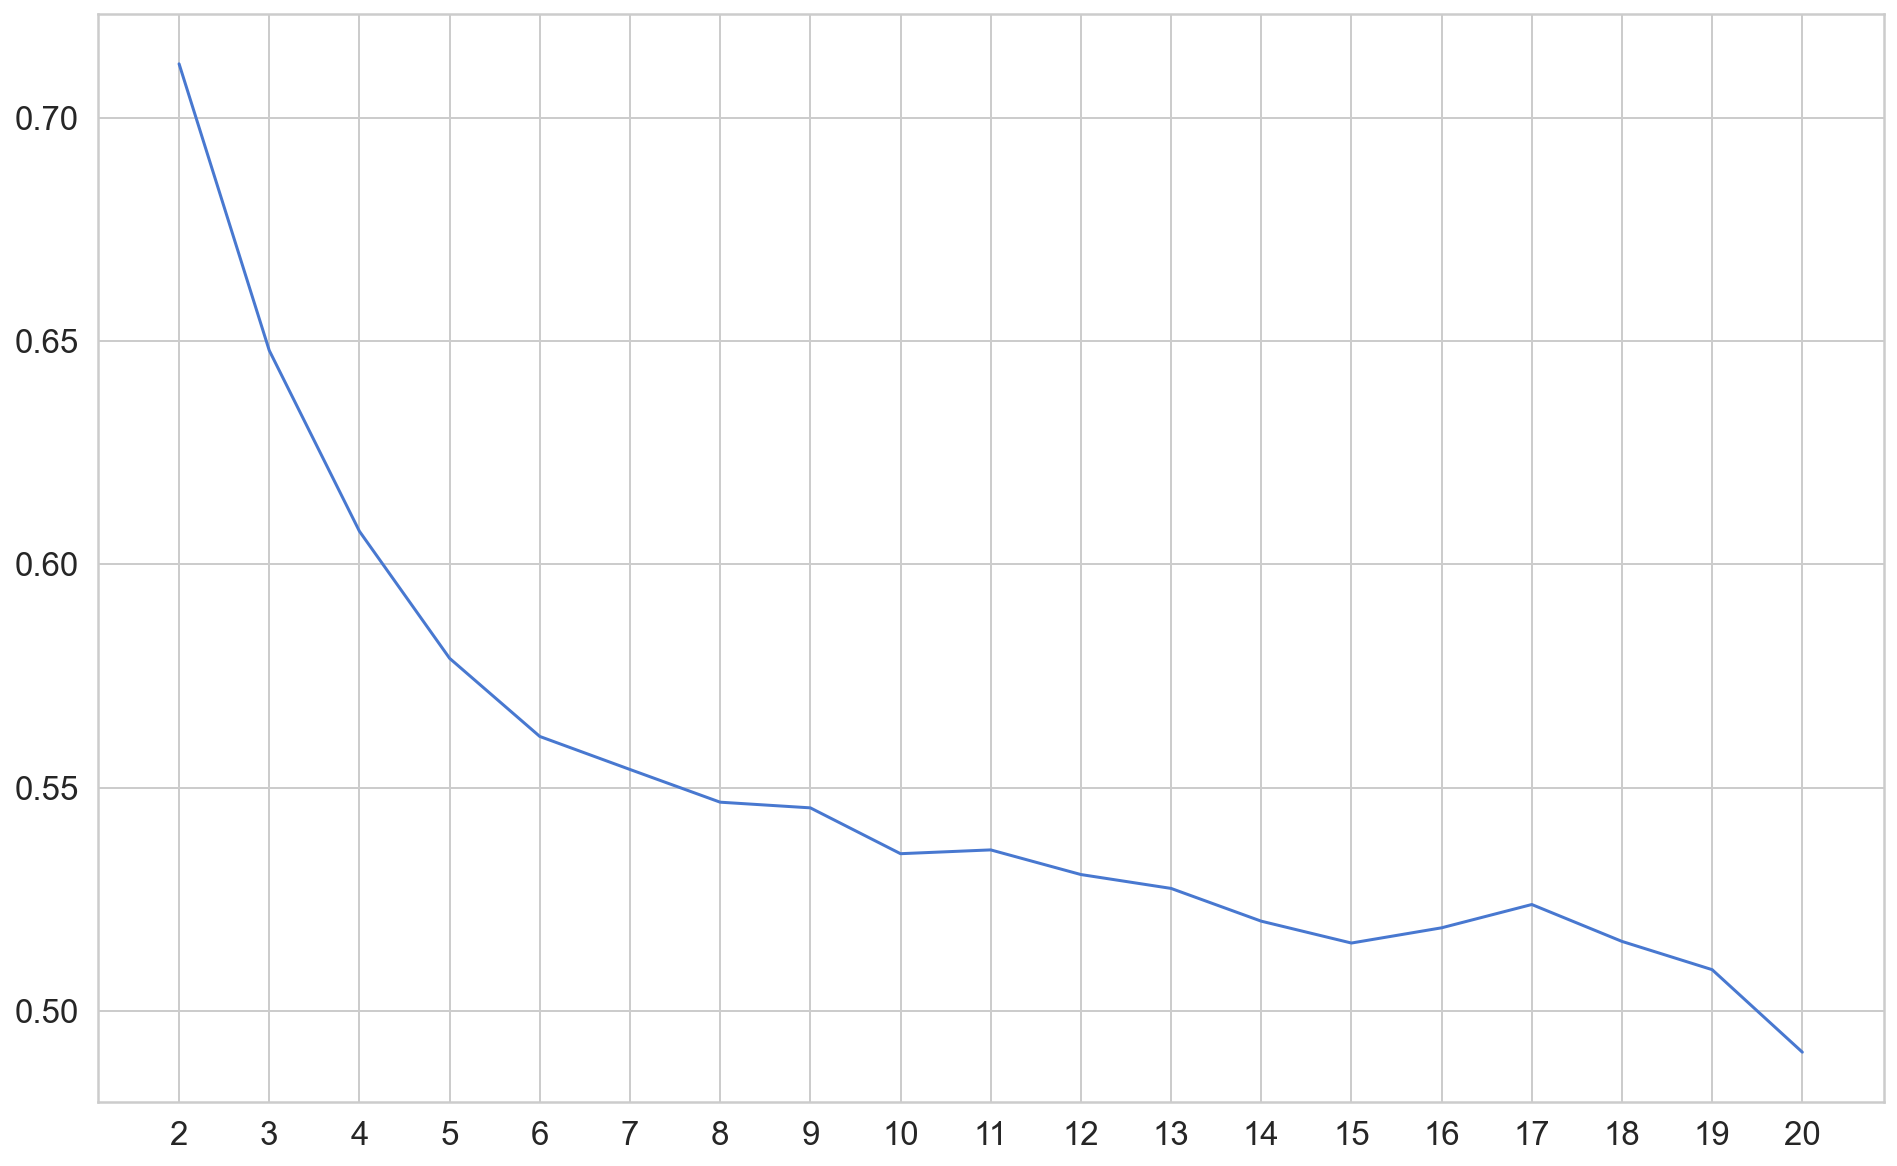

In [45]:
model_sscore(ddf)

In [46]:
ddf = preprocessing_pipeline.fit_transform(ddf) #after this I will keep this a ndarray

In [47]:
ddf #2D data now

array([[ 1.96058955, -0.9197299 ],
       [-0.91402937, -2.25283164],
       [ 1.11071331, -0.92623204],
       ...,
       [ 1.83672927,  0.44539576],
       [-0.37236046,  1.09899775],
       [-0.60788449,  0.48558048]])

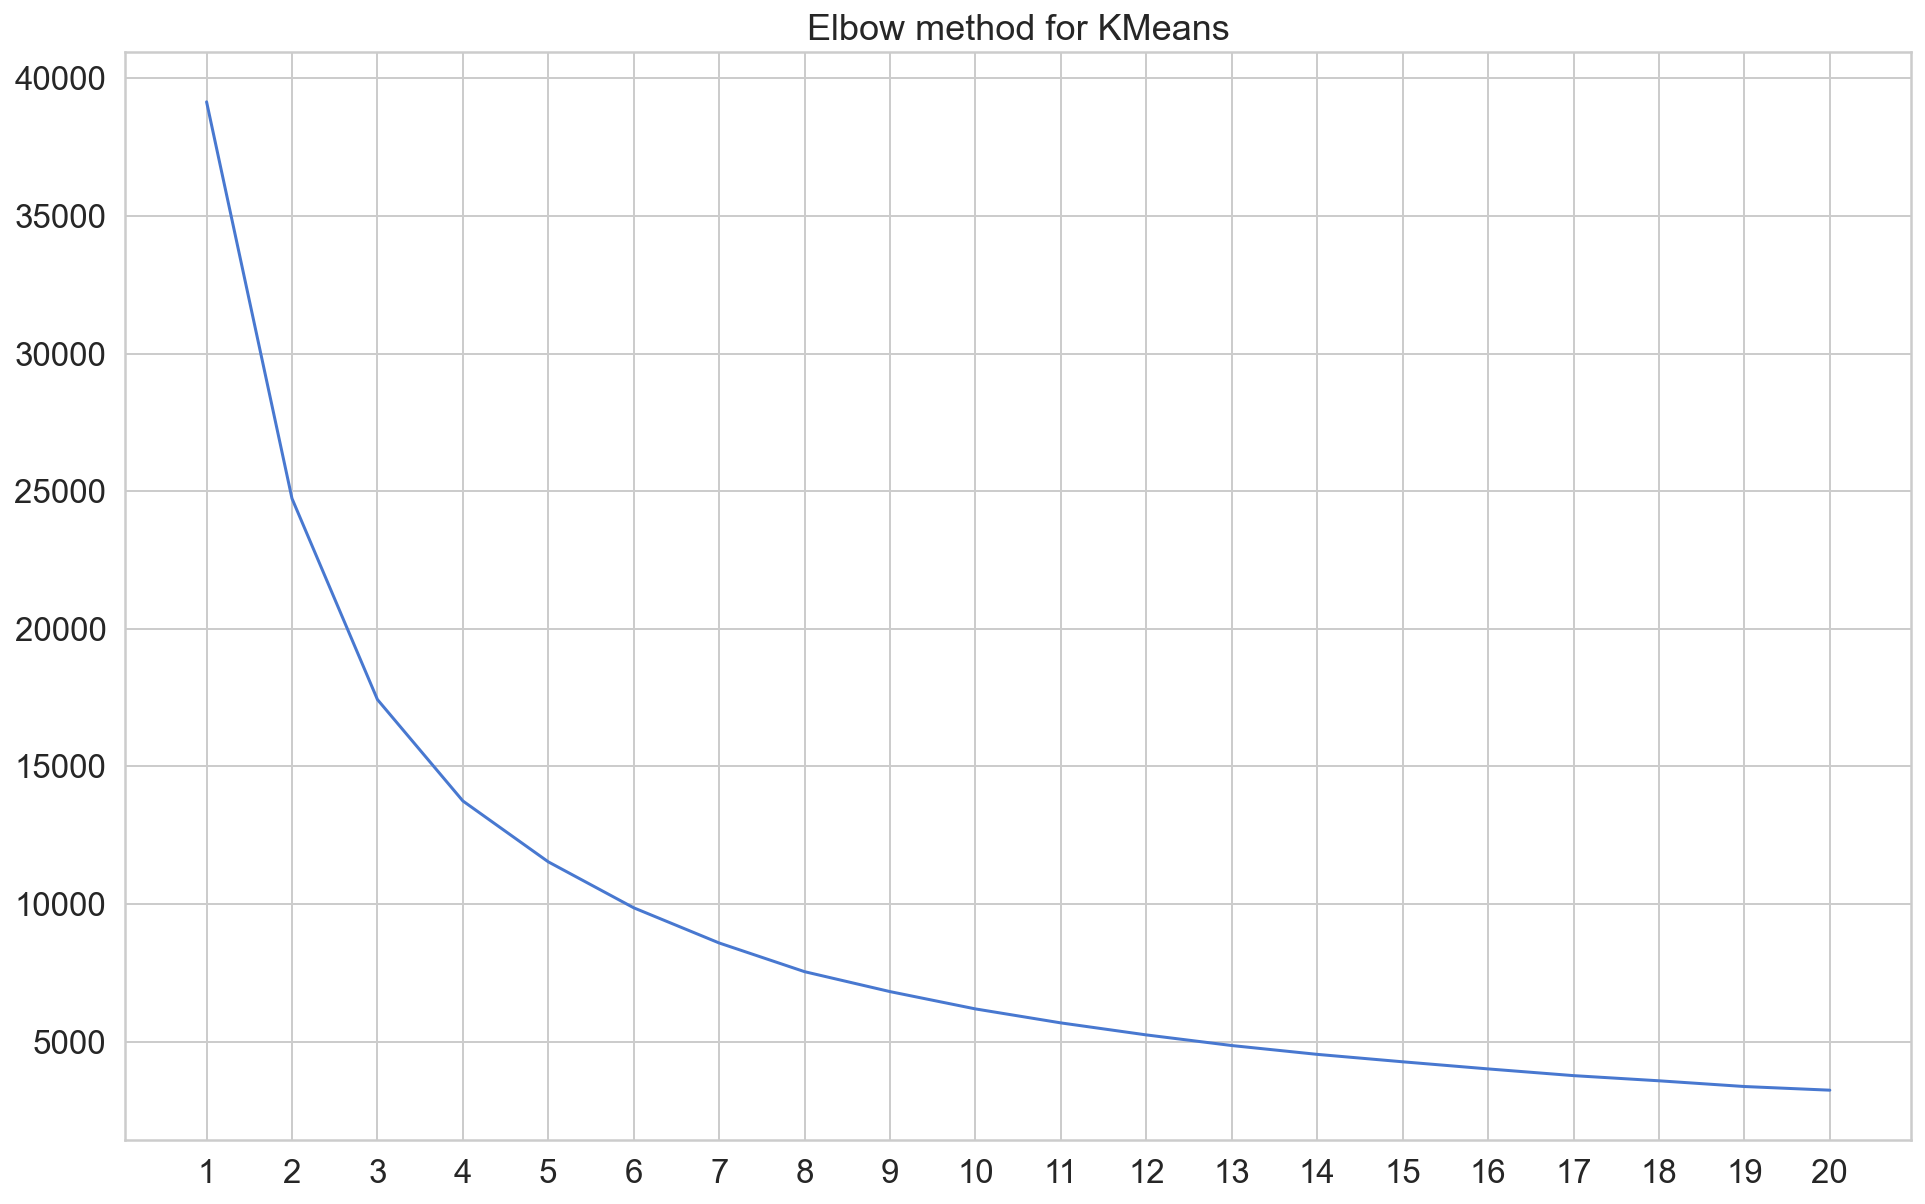

In [48]:
model_inertias(ddf) 

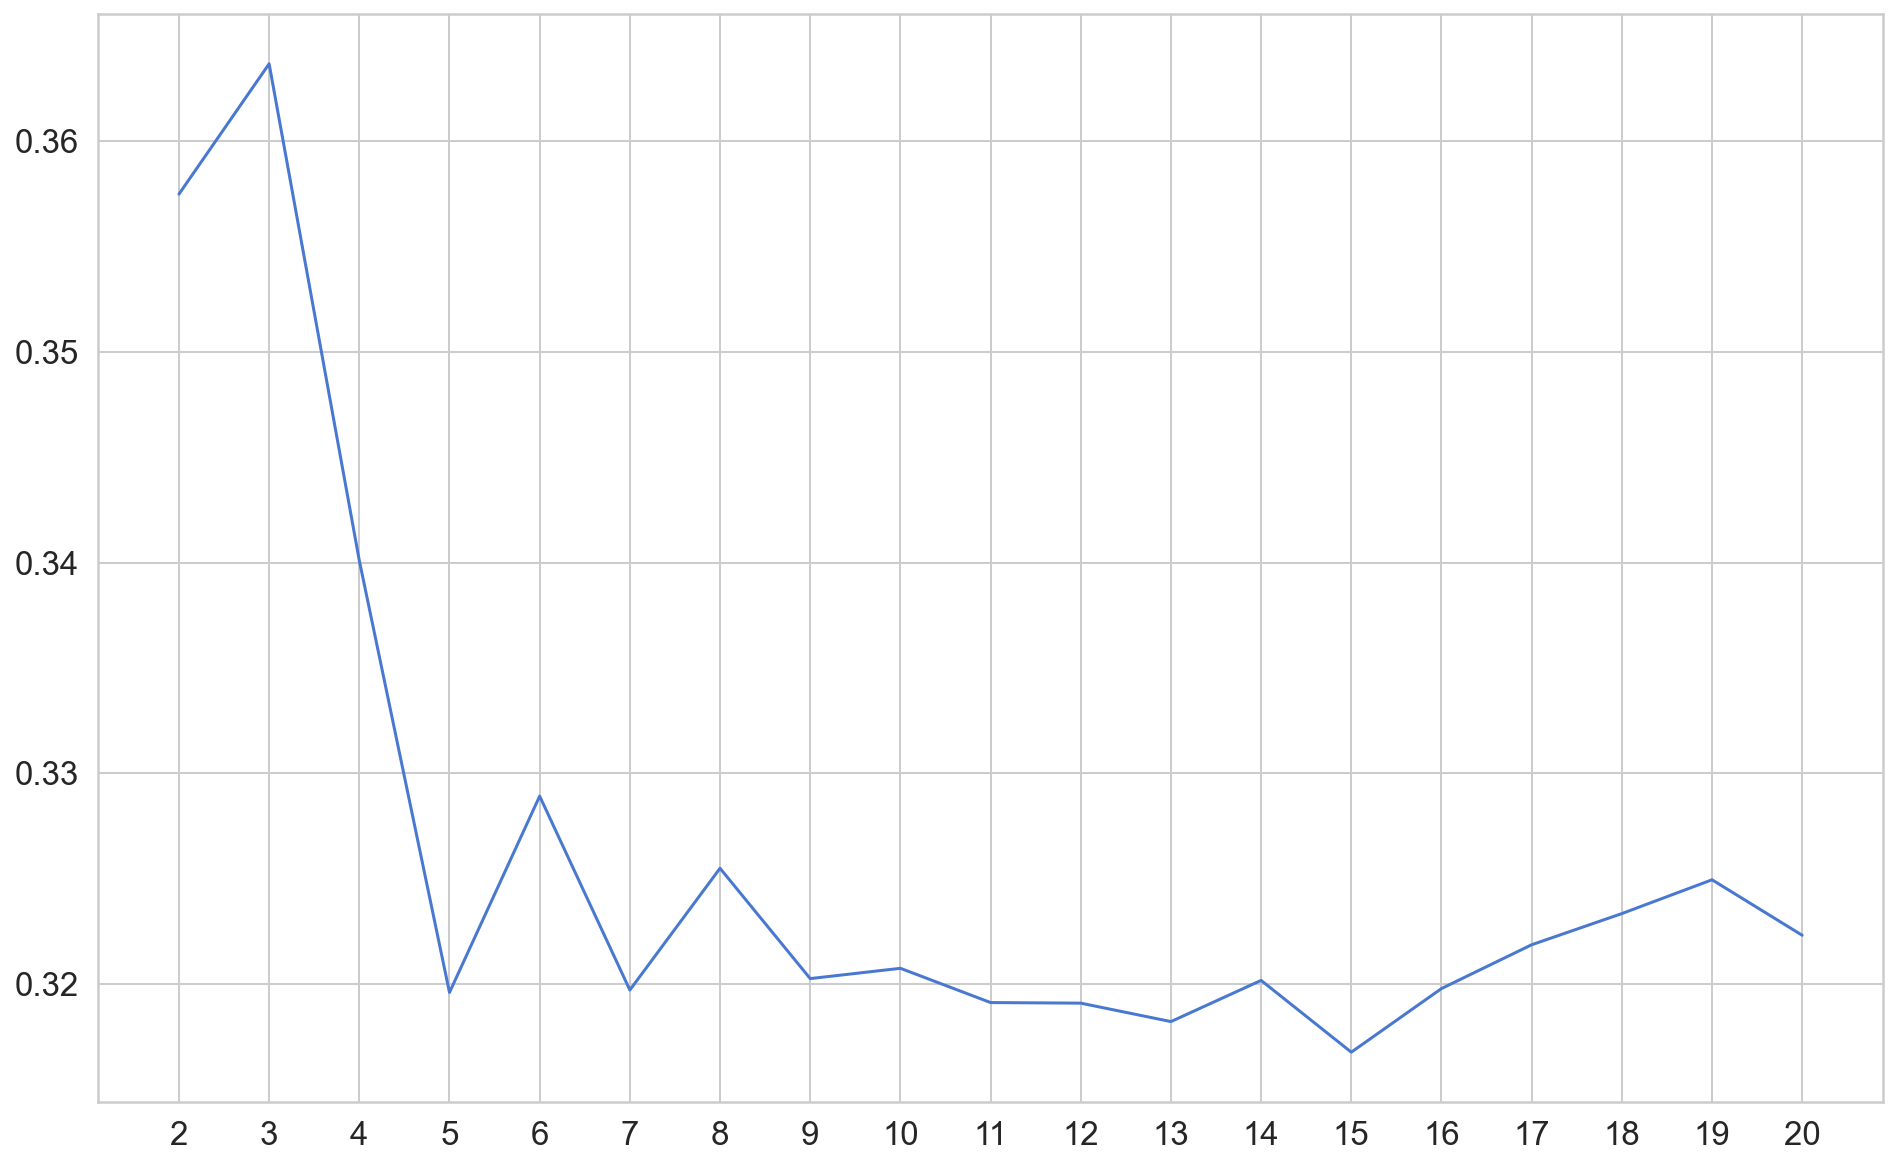

In [49]:
model_sscore(ddf)

So the number of clusters, if we use KMeans, is 6, even though this is not great. Let's see about DBSCAN. Let's have a looksie at the scatterplot, tho

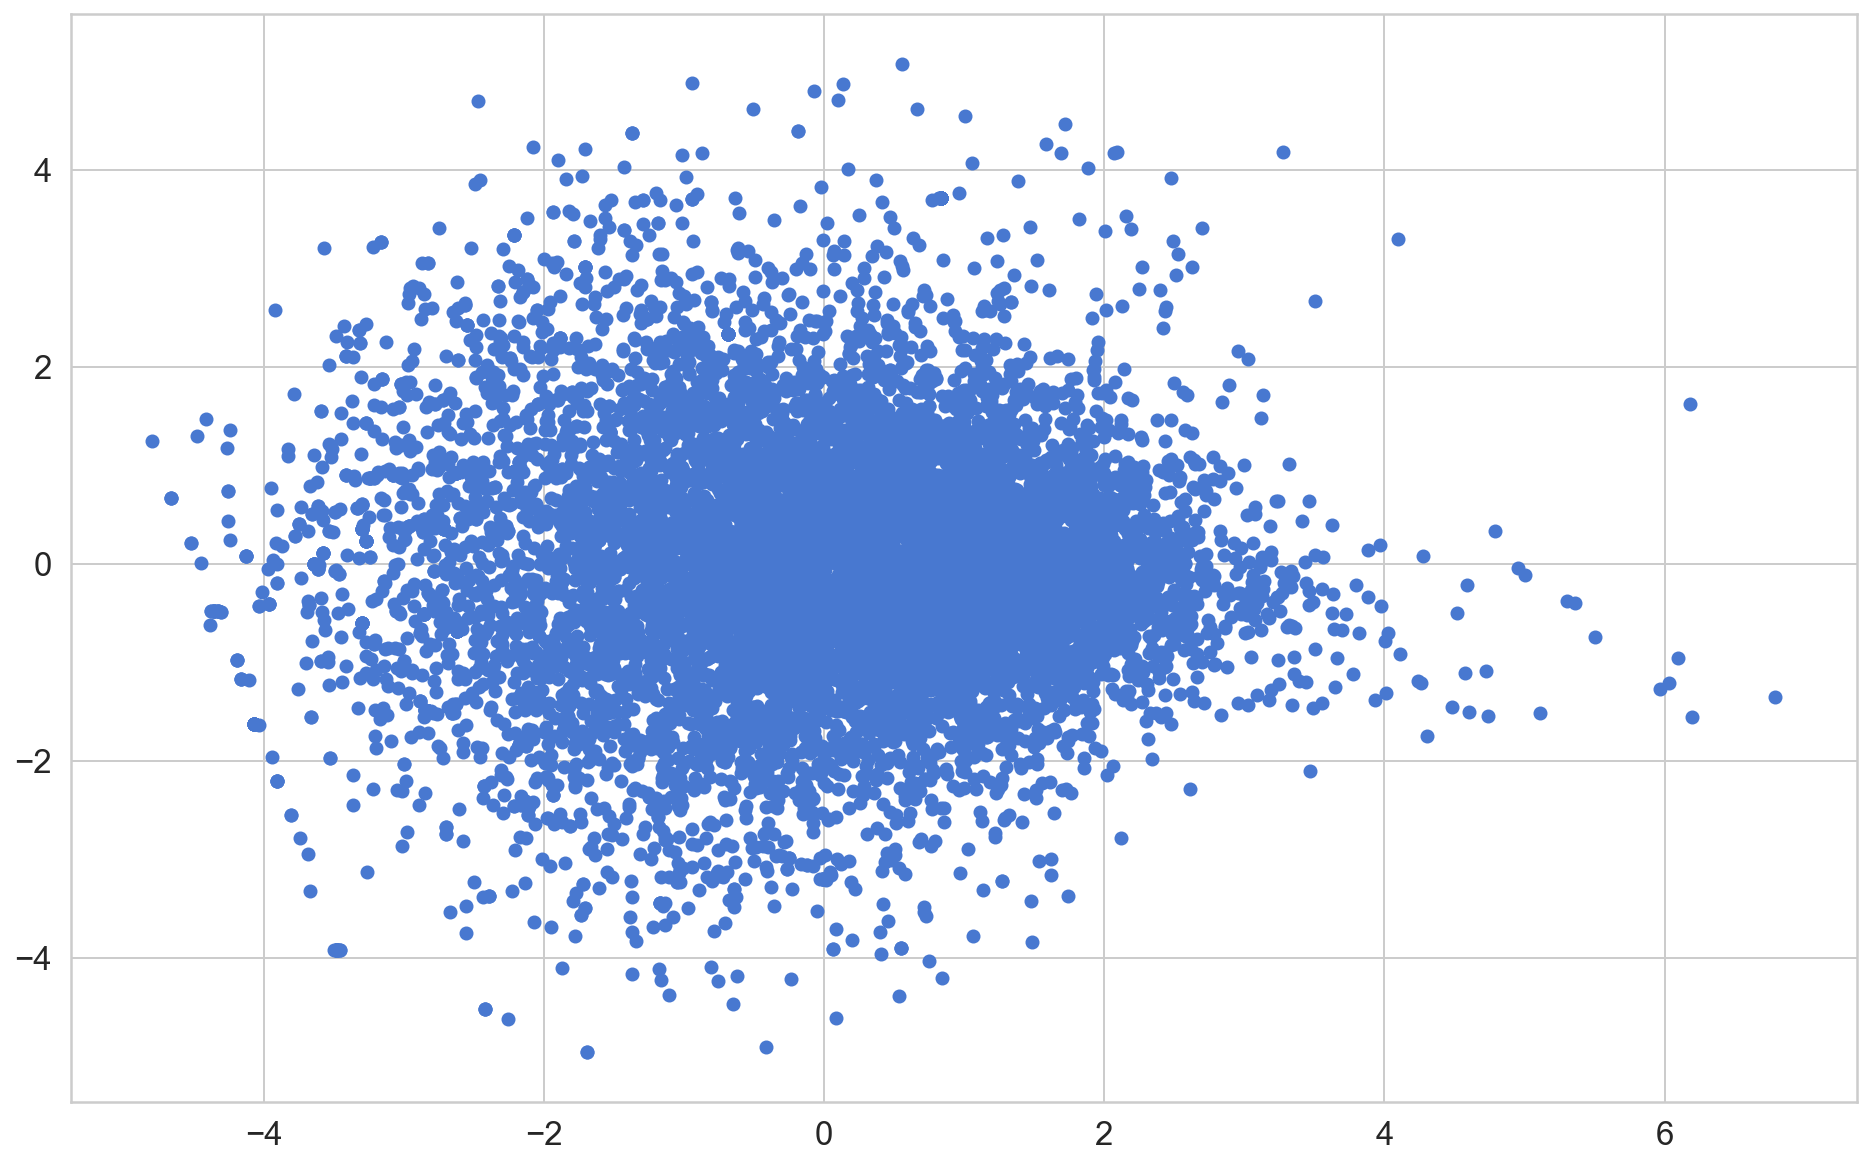

In [50]:
ddf = pd.DataFrame(ddf)
plt.scatter(x=ddf[0],y=ddf[1])
plt.show()

So performing clustering on this is OBVIOUSLY not a good idea. Whatever, for the sake of this miniproject I'll pretend there are some beautiful clusters and I"ll just continue with KMeans, since DBScan or any other density based algorithm would be inefficient.

In [51]:
#oh and let's get rid of the nulls in the original unvectorized dataset

vectorized_df2 = vectorized_df.copy() 
vectorized_df2.set_index(pd.Index(list(range(10000))),inplace=True)
indices_lookup = vectorized_df2[vectorized_df2['ADJ'].isnull()].index.tolist()
indices_lookup

[434, 4921, 5147, 7348]

In [52]:
vectorized_df2 = vectorized_df2.drop(vectorized_df2.index[indices_lookup])
len(vectorized_df2)

9996

In [67]:
df1 = df.copy()
df1 = df1.drop(df1.index[indices_lookup])
len(df1)

9996

### REFERENCE DFRAMES
- df1 (original data)
- vectorized_df2

In [56]:
#let's get back to the clustering
kmeans = KMeans(n_clusters=4) 
kmeans.fit(ddf)

KMeans(n_clusters=4)

In [68]:
df1['CLUSTER'] = pd.Series(kmeans.predict(ddf),dtype='int32') #adding clusters to the copy of the original data
df1.head()

,Hotel_Address,City,merged_review_text,Reviewer_Score,CLUSTER
0,19 21 Penywern Road Kensington and Chelsea Lon...,London,The staff were a bit cold at first but they g...,8.3,2.0
1,Singel 303 309 Amsterdam City Center 1012 WJ A...,Amsterdam,Nothing View from room Location,10.0,1.0
2,18 Avenue De Suffren Entr e au 22 rue Jean Rey...,Paris,The Eiffel is blocked by another building we ...,10.0,2.0
3,K rntner Ring 9 01 Innere Stadt 1010 Vienna Au...,Vienna,Nothing Attention to detail Glad and smiley s...,9.6,1.0
4,Kleine Stadtgutgasse 4 02 Leopoldstadt 1020 Vi...,Vienna,Nothing negative to mention Great location 15...,8.8,3.0


In [69]:
df1['CLUSTER'].value_counts()

2.0    3636
1.0    2578
0.0    2321
3.0    1457
Name: CLUSTER, dtype: int64

In [70]:
df1.to_csv('df_clustered.csv', index=False)

In [ ]:
ddf['CLUSTER'] = pd.Series(kmeans.predict(ddf),dtype='int32')

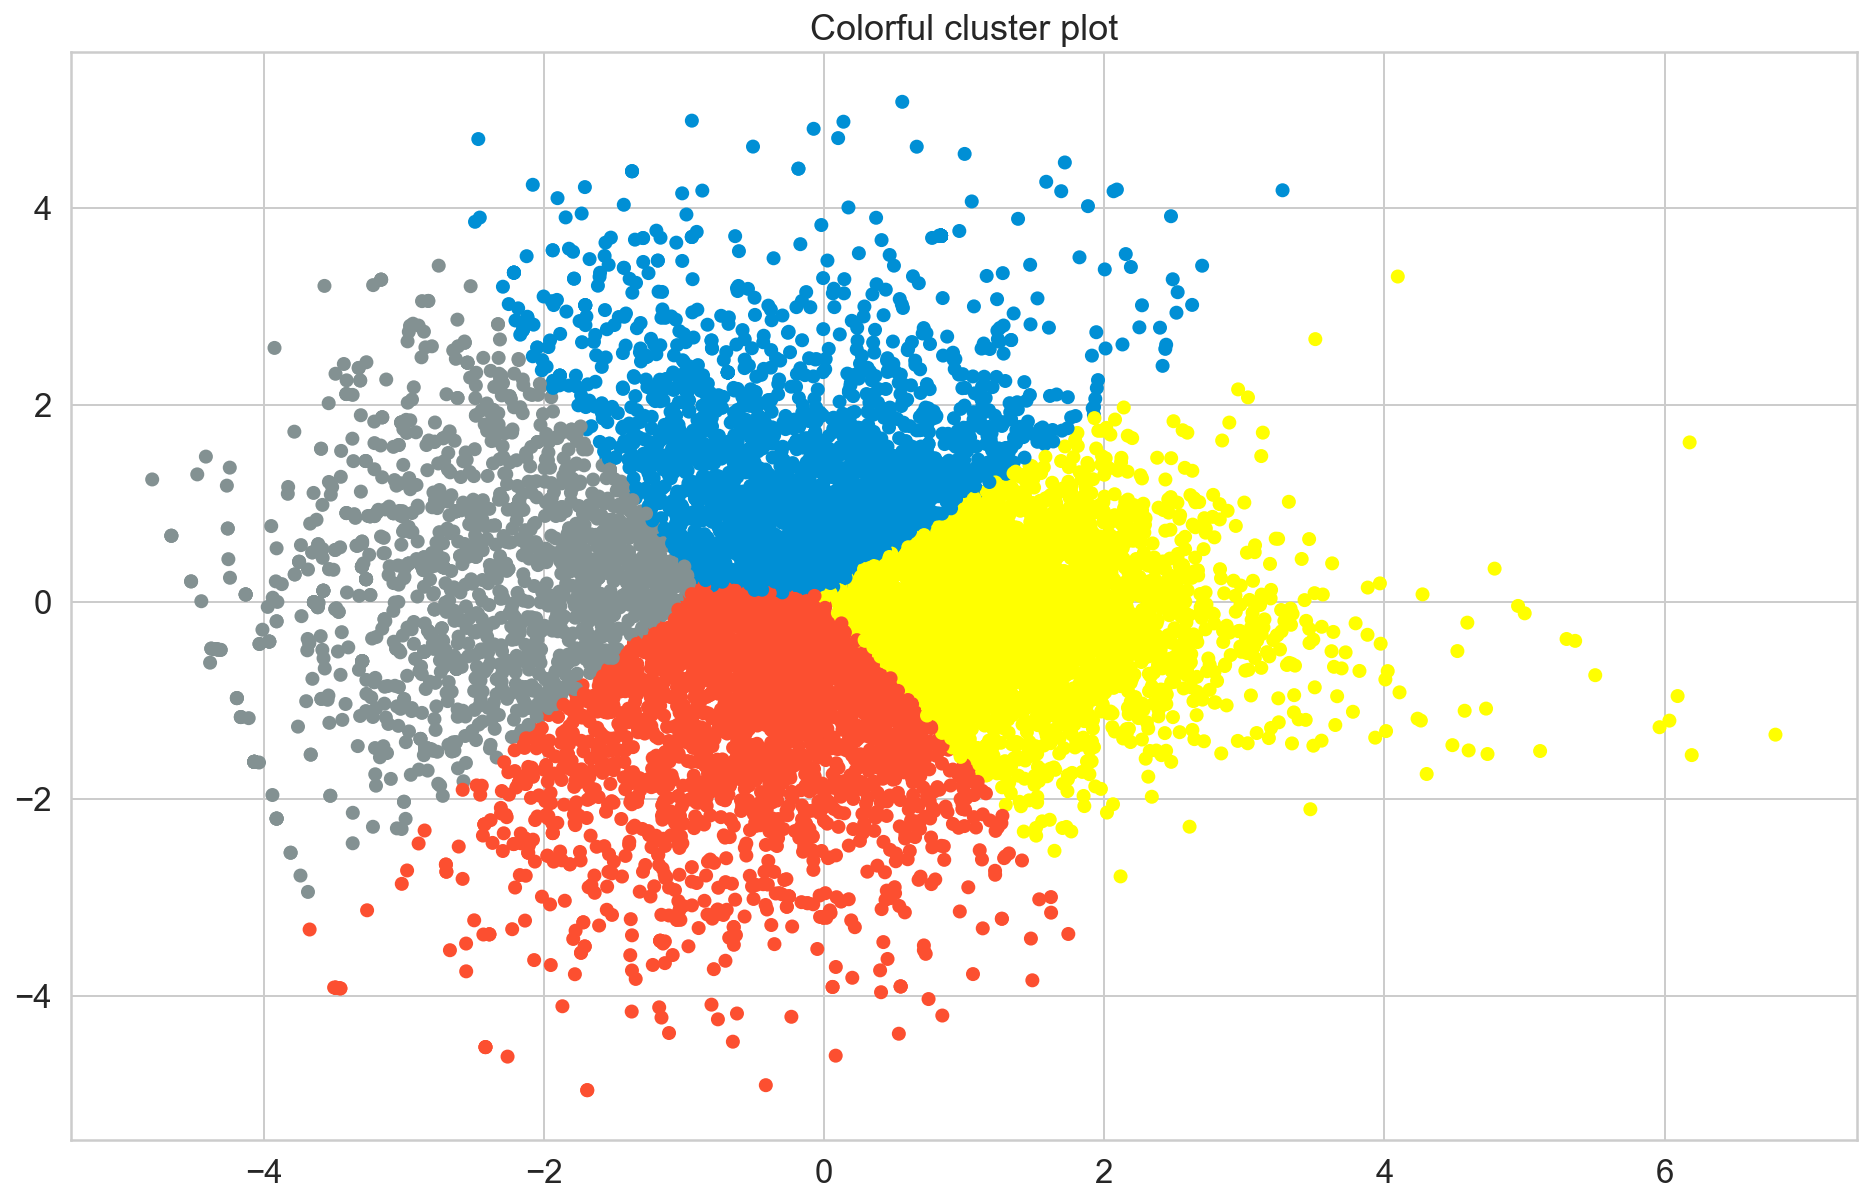

In [75]:
#let's display the clusters on a very colorful plot

fig, ax = plt.subplots()

fte_colors = {0.0: "#008fd5",
             1.0: "#fc4f30",
             2.0: '#FFFF00',
             3.0: '#839192'}

#the plot
km_colors = [fte_colors[label] for label in kmeans.labels_]
ax.scatter(ddf[0], ddf[1], c = km_colors)
ax.set_title('Colorful cluster plot')
plt.show()

## CUSTOMER PREDICTION

Now all we need is make a text representing a possible customer prediction inputs.

In [76]:
#at the input the customer would be supposed to enter the desired city first, let's suppose it's Vienna

city = 'Vienna'

test_string = 'I would very much like a fancy appartment furnished in a minimalistic way, not very far from the city centre, of course.'

In [82]:
#now we need to vectorize it the same way we vectorized the training data
test_df = pd.DataFrame(columns=type_list)
doc = nlp(test_string)
pos = pd.DataFrame()
for token in doc:
    pos.loc[token,'pos_'] = token.pos_
    #have the pos table    
test_vector = pd.DataFrame(pos['pos_'].value_counts()).reset_index()
test_vector = test_vector.transpose()
new_header = test_vector.iloc[0]
test_vector = test_vector[1:]
test_vector.columns = new_header #there's definitely a better, faster way but whatever
test_df = pd.concat([test_df,test_vector])
test_df.fillna(0, inplace=True)            
test_df['sum'] = test_df.sum(axis=1)
test_df.loc[:,"ADJ":"X"] = test_df.loc[:,"ADJ":"X"].div(test_df["sum"], axis=0)
test_df = test_df.drop('SPACE', axis=1)

test_df

,ADJ,ADP,ADV,AUX,CONJ,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,sum
pos_,0.08,0.12,0.16,0.0,0.0,0.0,0.12,0.0,0.2,0.0,0.04,0.04,0.0,0.12,0.04,0.0,0.08,0.0,25


In [83]:
#now we need to pass it through the same preprocessing pipeline as the training data, thus use only transform, not fit
test_df = preprocessing_pipeline.transform(test_df)

In [84]:
#now we need to predict it
predicted_cluster = kmeans.predict(test_df)
predicted_cluster

array([1])

This string's predicted cluster is 1. Let's get some nice-looking output as a final step of this notebook.

In [106]:
print('Your desired destination is {}.'.format(city))
print('Here is a recommendation of 5 adresses based on your writing style and reviews of other users: ')

for i,a in enumerate(df1[(df1['City'].isin([city])) & (df1['CLUSTER'].isin([predicted_cluster]))]
                     .sort_values(by=['Reviewer_Score']).drop_duplicates(subset='Hotel_Address').head()['Hotel_Address']):
    print('Tip nr. {}: '.format(i+1), a)



Your desired destination is Vienna.
Here is a recommendation of 5 adresses based on your writing style and reviews of other users: 
Tip nr. 1:  Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria
Tip nr. 2:  Schwedenplatz 3 4 01 Innere Stadt 1010 Vienna Austria
Tip nr. 3:  Rennweg 12a 03 Landstra e 1030 Vienna Austria
Tip nr. 4:  Kirchberggasse 6 07 Neubau 1070 Vienna Austria
Tip nr. 5:  Parkring 12 01 Innere Stadt 1010 Vienna Austria
